# Use IMGUR to host many cat images   

We will rely on IMGUR to host many cat images so we can build a website to show cats sorted from pretty to ugly without paying for 9k cat images being hosted in some bucket.  

We will clean and export a cat dataset, upload to IMGUR, then use https://imgur.plen.io/ to get the image links for the next step.  

## install libs

In [ ]:
%%capture
!pip install datasets

## load and transform a cat dataset

We rely on a HF Hub dataset containing cat images.  

Problem: it contains duplicated images!  

We will:

1. remove duplicates  
2. upload clean version to the hub for later use (if needed)
3. save all images to a .jpg format and download a .zip file of these pics for IMGUR upload.  

### load base dataset

In [ ]:
from datasets import load_dataset

cats_ds = load_dataset('huggan/cats', split='train')
cats_ds

Generating train split:   0%|          | 0/19994 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 19994
})

### filter on unique cats  

It turns out the dataset only contains 9k unique cats.  

In [ ]:
from datasets import Dataset

cats_df = cats_ds.to_pandas()
cats_df.drop_duplicates(subset=['image'], inplace=True)
cats_ds = Dataset.from_pandas(cats_df, preserve_index=False)
cats_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 9936
})

### save deduped dataset to the hub

In [ ]:
cats_ds.push_to_hub('the-french-artist/unique_9k_cats')

Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/the-french-artist/unique_9k_cats/commit/5c84873ecbc4a0f432abc19acd206348a892ccf4', commit_message='Upload dataset', commit_description='', oid='5c84873ecbc4a0f432abc19acd206348a892ccf4', pr_url=None, pr_revision=None, pr_num=None)

### overwrite load_image function to read from bytes

In [ ]:
from PIL import Image
import io

def load_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    return image

# Example usage:
image_data = cats_df.head(1).image.values[0]
image = load_image(image_data['bytes'])

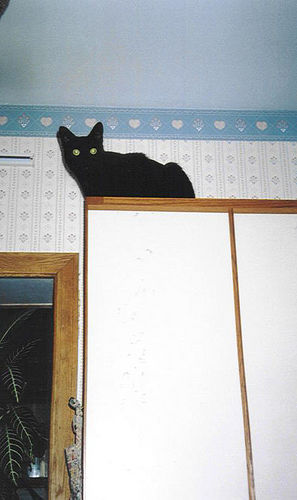

In [ ]:
display(image)

### save image to dir

In [ ]:
!mkdir cat_export

In [ ]:
cats_df

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
...,...,...
14776,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4
14777,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4
14778,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4
14779,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4


In [ ]:
import os
import pandas as pd
from PIL import Image
import io

def save_images_from_dataframe(df, folder_name):
    # Create the directory if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Iterate over the rows in the dataframe
    for index, row in df.iterrows():
        # Get the binary data
        image_data = row['image']

        # Convert binary data to an image
        image = Image.open(io.BytesIO(image_data['bytes']))

        # Define the filename
        filename = os.path.join(folder_name, f'image_{index}.jpg')

        # Save the image
        image.save(filename)

# Example usage
# Assuming your dataframe is loaded into the variable cats_df
save_images_from_dataframe(cats_df, 'cat_export')


In [ ]:
import shutil
from google.colab import files

def zip_and_download_folder(folder_name):
    # Define the zip file name
    zip_file_name = f'{folder_name}.zip'

    # Create a zip file from the folder
    shutil.make_archive(folder_name, 'zip', folder_name)

    # Download the zip file
    files.download(zip_file_name)

# Example usage
zip_and_download_folder('cat_export')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This is slow AF so we go through GDrive instead:

In [ ]:
!cp /content/cat_export.zip /content/drive/MyDrive/AI/cats

## Conclusion: FAILURE.  

We cannot use IMGUR as their usage limits are waaaay below what we are trying to do.  

We will instead rely on a GCP bucket.  